In [72]:
import os
import clip
import torch
from torchvision.datasets import CIFAR100

# Load the model
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device)
print("Model loaded on", device)

Model loaded on mps


In [73]:
from skimage import io, transform
from PIL import Image
import numpy as np
from tqdm import tqdm

In [ ]:
# Get images
MSRVTT_IMG_DIR = os.path.join("../syn_data/msrvtt_imgs/")

# Load all images in the directory
processed_images = []
for img_name in tqdm(os.listdir(MSRVTT_IMG_DIR)):
    img_path = os.path.join(MSRVTT_IMG_DIR, img_name)
    if img_name.endswith(".jpg"):
        image_mat = io.imread(img_path)
        image_mat = Image.fromarray((image_mat * 255).astype(np.uint8))
        preprocessed_image = preprocess(image_mat).unsqueeze(0).to(device)
        processed_images.append(preprocessed_image)
        

In [77]:
# Embed all images from CIFAR-100 dataset
all_image_features = []

for img in tqdm(processed_images):
    with torch.no_grad():
        image_features = model.encode_image(img)
        image_features /= image_features.norm(dim=-1, keepdim=True)
    
    all_image_features.append(image_features)

# Convert list to tensor
all_image_features = torch.cat(all_image_features)

100%|██████████| 10000/10000 [02:10<00:00, 76.59it/s]


In [79]:
all_image_features.device

device(type='mps', index=0)

In [80]:
all_image_features.shape

torch.Size([10000, 512])

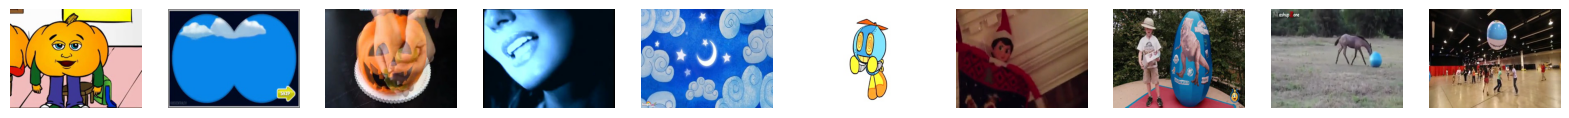

In [93]:
# Encode the text "a cat"
text = clip.tokenize(["pumpkin"]).to(device)

with torch.no_grad():
    text_features = model.encode_text(text)
    text_features /= text_features.norm(dim=-1, keepdim=True)

# Compute the similarity between the text embedding and all image embeddings
similarities = (all_image_features @ text_features.T).squeeze()

import matplotlib.pyplot as plt

# Find the indices of the top 5 most similar images
top_5_indices = similarities.topk(10).indices

# Load and display the top 5 matching images
fig, axes = plt.subplots(1, 10, figsize=(20, 4))
for ax, idx in zip(axes, top_5_indices):
    img_name = os.listdir(MSRVTT_IMG_DIR)[idx]
    img_path = os.path.join(MSRVTT_IMG_DIR, img_name)
    img = Image.open(img_path)
    ax.imshow(img)
    ax.axis('off')
plt.show()